# 📊 Chunking Strategy Evaluation Demo

This notebook demonstrates how to evaluate different document chunking strategies for RAG (Retrieval-Augmented Generation) systems.

## 🎯 What You'll Learn
- How different chunking strategies work
- How to evaluate chunking performance using RAGAS metrics
- How to compare strategies and interpret results
- Best practices for choosing chunking strategies

## 📚 Available Chunking Strategies
1. **Baseline**: Simple character-based splitting
2. **Recursive Character**: Hierarchical text splitting with overlap
3. **Unstructured**: Structure-aware chunking using titles and sections
4. **Docling**: Advanced document parsing with hybrid chunking


## 🛠️ Setup and Imports


In [11]:
# Standard library imports
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Project imports
from retrieval_playground.src.pre_retrieval.chunking_evaluation import ChunkingEvaluator
from retrieval_playground.src.pre_retrieval.chunking_strategies import PreRetrievalChunking, ChunkingStrategy
from retrieval_playground.utils import config
from retrieval_playground.utils import constants

print("✅ All imports successful!")
print(f"📁 Sample papers directory: {config.SAMPLE_PAPERS_DIR}")
print(f"📊 Results will be stored in: {config.RESULTS_DIR}")


✅ All imports successful!
📁 Sample papers directory: /Users/aartijha/Desktop/retrieval-playground/retrieval_playground/data/sample_research_papers
📊 Results will be stored in: /Users/aartijha/Desktop/retrieval-playground/retrieval_playground/data/results


## 📄 Sample Data Overview

Let's explore the sample research papers we'll be working with:


In [12]:
# List available PDF files
pdf_files = list(config.SAMPLE_PAPERS_DIR.glob("*.pdf"))
print(f"📚 Found {len(pdf_files)} research papers:")
print("="*60)

for i, pdf_file in enumerate(pdf_files, 1):
    file_size = pdf_file.stat().st_size / (1024 * 1024)  # Convert to MB
    # Extract topic from filename
    topic = pdf_file.stem.split('_')[0]
    title = pdf_file.stem.replace('_', ' ').replace(topic + ' 2025 ', '')
    print(f"{i}. 🔬 {topic}")
    print(f"   📖 {title[:60]}{'...' if len(title) > 60 else ''}")
    print(f"   💾 Size: {file_size:.1f} MB")
    print()

# Load test queries to understand evaluation criteria
with open(config.TESTS_DIR / "test_queries.json", 'r') as f:
    test_queries = json.load(f)

print(f"❓ Test queries: {len(test_queries)} evaluation questions")
print("\n📝 Sample query:")
print(f"Question: {test_queries[0]['user_input'][:100]}...")
print(f"Source: {test_queries[0]['source_file']}")


📚 Found 5 research papers:
1. 🔬 Generative
   📖 Generative AI 2025 Frozen in Time  Parameter-Efficient Time ...
   💾 Size: 0.4 MB

2. 🔬 Machine
   📖 Machine Learning 2025 AdLoCo  adaptive batching significantl...
   💾 Size: 0.4 MB

3. 🔬 Statistics
   📖 Alternative statistical inference for the first normalized i...
   💾 Size: 0.4 MB

4. 🔬 Computer
   📖 Computer Vision 2025 Fence off Anomaly Interference  Cross-D...
   💾 Size: 28.9 MB

5. 🔬 Analytics
   📖 Graph-R1  Incentivizing the Zero-Shot Graph Learning Capabil...
   💾 Size: 0.5 MB

❓ Test queries: 5 evaluation questions

📝 Sample query:
Question: How does MC3G improve upon existing counterfactual explanation methods, particularly concerning cost...
Source: Analytics_2025_MC3G__Model_Agnostic_Causally_Constrained_Counterfactual_Generation.pdf


## 🔧 Chunking Strategies Explained

Let's understand how each chunking strategy works:


In [3]:
# Initialize chunking processor
chunker = PreRetrievalChunking()

# Display available strategies
strategies = chunker.get_available_strategies()
print("🎯 Available Chunking Strategies:")
print("="*50)

strategy_descriptions = {
    ChunkingStrategy.BASELINE: {
        "name": "Baseline Character Splitting",
        "description": "Simple text splitting by character count with newline separators",
        "pros": ["Fast and simple", "Consistent chunk sizes"],
        "cons": ["May break sentences/paragraphs", "No semantic awareness"]
    },
    ChunkingStrategy.RECURSIVE_CHARACTER: {
        "name": "Recursive Character Splitting",
        "description": "Hierarchical splitting that tries to preserve document structure",
        "pros": ["Respects document structure", "Good chunk overlap", "Preserves context"],
        "cons": ["More complex", "Variable chunk sizes"]
    },
    ChunkingStrategy.UNSTRUCTURED: {
        "name": "Unstructured Title-Based",
        "description": "Uses document structure (titles, sections) for intelligent chunking",
        "pros": ["Structure-aware", "Semantic coherence", "Good for academic papers"],
        "cons": ["Slower processing", "Requires structured documents"]
    },
    ChunkingStrategy.DOCLING: {
        "name": "Docling Hybrid Chunking",
        "description": "Advanced parsing with markdown conversion and hybrid chunking",
        "pros": ["Best structure preservation", "Handles complex layouts", "Markdown output"],
        "cons": ["Most resource intensive", "Complex setup"]
    }
}

for strategy in strategies:
    info = strategy_descriptions[strategy]
    print(f"\n🔹 {info['name']} ({strategy.value})")
    print(f"   {info['description']}")
    print(f"   ✅ Pros: {', '.join(info['pros'])}")
    print(f"   ⚠️  Cons: {', '.join(info['cons'])}")


2025-09-04 01:35:37.599 INFO model_manager - _initialize_models: 🔄 ModelManager: Initializing shared AI models...
2025-09-04 01:35:45.385 INFO model_manager - _initialize_models: ✅ ModelManager: Shared AI models initialized successfully
2025-09-04 01:35:45.387 INFO chunking_strategies - _init_chunking_strategies: ✅ All chunking strategies initialized
2025-09-04 01:35:45.387 INFO chunking_strategies - __init__: ✅ PreRetrievalChunking initialized
🎯 Available Chunking Strategies:

🔹 Baseline Character Splitting (baseline)
   Simple text splitting by character count with newline separators
   ✅ Pros: Fast and simple, Consistent chunk sizes
   ⚠️  Cons: May break sentences/paragraphs, No semantic awareness

🔹 Recursive Character Splitting (recursive_character)
   Hierarchical splitting that tries to preserve document structure
   ✅ Pros: Respects document structure, Good chunk overlap, Preserves context
   ⚠️  Cons: More complex, Variable chunk sizes

🔹 Unstructured Title-Based (unstructure

## Qdrant Collections Overview

Let's explore the collections available in qdrant cloud. You can replace the key and url with your own cloud as well

In [13]:
from qdrant_client import QdrantClient

qdrant_client = QdrantClient(
    url=constants.QDRANT_URL, 
    api_key=constants.QDRANT_KEY,
)

print(qdrant_client.get_collections())

2025-09-16 11:29:30,027 - INFO - HTTP Request: GET https://1d20b7dd-e936-4d2e-b034-c62a8dc85ef5.us-east4-0.gcp.cloud.qdrant.io:6333 "HTTP/1.1 200 OK"
2025-09-16 11:29:30,948 - INFO - HTTP Request: GET https://1d20b7dd-e936-4d2e-b034-c62a8dc85ef5.us-east4-0.gcp.cloud.qdrant.io:6333/collections "HTTP/1.1 200 OK"


collections=[CollectionDescription(name='docling'), CollectionDescription(name='unstructured'), CollectionDescription(name='baseline'), CollectionDescription(name='recursive_character')]


In [14]:
scroll_iter = qdrant_client.scroll(
    collection_name="baseline",
    limit=1,             # batch size
    with_payload=True,
    with_vectors=False    # set True if you also need vectors
)

points, next_page = scroll_iter
for p in points:
    print(p)

2025-09-16 11:29:31,220 - INFO - HTTP Request: POST https://1d20b7dd-e936-4d2e-b034-c62a8dc85ef5.us-east4-0.gcp.cloud.qdrant.io:6333/collections/baseline/points/scroll "HTTP/1.1 200 OK"


id='0025580a-754e-4fed-9c65-c5c8eff536ea' payload={'page_content': 'edge classification), ensuring broad coverage for\nevaluating graph reasoning.\nGraph-to-text augmentation. Unlike prior work\nthat tokenizes structural features using GNN en-\ncoders, we revisit the pure graph-to-text paradigm.\nTaking node-level tasks as an example, for a target\nnode vi, we extract itsh-hop subgraph and describe\nall node features Ti = {x(vj) | j ∈ N(i) ∪ {i}},\nand edge relations Ei = {x(ejk) | vj, vk ∈\nN(i) ∪ {i}} within the subgraph using natural lan-\nguage, where N(i) is the neighborhood of vi. To\nmaintain input tractability for large graphs with\nverbose node texts (e.g., citation networks with ti-\ntles and abstracts), we apply DEEP SEEK -V3 for\nautomatic summarization. Prompt templates are\nprovided in Appendix B.\nReasoning-trace extraction. A distinctive fea-\nture of our dataset construction is the inclusion of\nexplicit reasoning traces for each answer. Specif-\nically, each subgraph 

## 🏗️ Creating Chunks (Optional)

**Note**: This step is optional if chunks have already been created. The evaluation will skip chunk creation if vector stores already exist.


In [4]:
# Check if chunks already exist
existing_strategies = []
for strategy in strategies:
    qdrant_path = config.QDRANT_DIR / strategy.value
    if qdrant_path.exists() and any(qdrant_path.iterdir()):
        existing_strategies.append(strategy.value)

if existing_strategies:
    print(f"✅ Found existing chunks for: {', '.join(existing_strategies)}")
    print("⏩ Skipping chunk creation...")
else:
    print("🏗️ No existing chunks found. Creating chunks for all strategies...")
    print("⚠️  This may take several minutes depending on your system.")
    
    # Uncomment the line below to create chunks
    # chunker.create_chunks_for_all_strategies(str(config.SAMPLE_PAPERS_DIR))
    
    print("\n💡 To create chunks, uncomment the line above and run this cell.")
    print("   This is a one-time setup that processes all PDFs for each strategy.")


✅ Found existing chunks for: baseline, recursive_character, unstructured, docling
⏩ Skipping chunk creation...


## 📊 Running the Evaluation

Now let's evaluate all chunking strategies using RAGAS metrics:

### 🎯 Evaluation Metrics
- **Answer Relevancy**: How relevant the generated answer is to the question
- **Faithfulness**: How well the answer is grounded in the retrieved context
- **Context Precision**: How precise the retrieved context is
- **Context Recall**: How well the retrieved context covers the ground truth


In [5]:
# Initialize evaluator
evaluator = ChunkingEvaluator()

print("🚀 Starting comprehensive chunking evaluation...")
print(f"📝 Evaluating {len(test_queries)} queries across {len(strategies)} strategies")
print("⏱️  This may take a few minutes...\n")

# Run evaluation
try:
    results_df = evaluator.evaluate_all_strategies()
    print("\n✅ Evaluation completed successfully!")
    
    # Display basic info about results
    print(f"📊 Results shape: {results_df.shape}")
    print(f"📈 Strategies evaluated: {results_df['strategy'].nunique()}")
    print(f"❓ Queries processed: {results_df['queries'].nunique()}")
    
except Exception as e:
    print(f"❌ Evaluation failed: {e}")
    print("\n💡 Make sure you have:")
    print("   1. Created chunks for at least one strategy")
    print("   2. Proper API keys configured")
    print("   3. All dependencies installed")
    
    # Create sample data for demonstration
    print("\n🎭 Creating sample data for demonstration...")
    sample_data = []
    for strategy in ['baseline', 'recursive_character', 'unstructured', 'docling']:
        for query in test_queries[:2]:  # Use first 2 queries
            sample_data.append({
                'strategy': strategy,
                'queries': query['user_input'],
                'answer_relevancy': 0.7 + (hash(strategy + query['user_input']) % 30) / 100,
                'faithfulness': 0.6 + (hash(strategy + query['user_input'] + 'f') % 35) / 100,
                'context_precision': 0.65 + (hash(strategy + query['user_input'] + 'p') % 30) / 100,
                'context_recall': 0.5 + (hash(strategy + query['user_input'] + 'r') % 40) / 100,
            })
    
    results_df = pd.DataFrame(sample_data)
    results_df['average_score'] = results_df[['answer_relevancy', 'faithfulness', 'context_precision', 'context_recall']].mean(axis=1)
    print("✅ Sample data created for demonstration")


2025-09-04 01:36:42.027 INFO evaluation - __init__: ✅ RAGEvaluator initialized
2025-09-04 01:36:42.029 INFO chunking_evaluation - __init__: ✅ Loaded 5 test queries
🚀 Starting comprehensive chunking evaluation...
📝 Evaluating 5 queries across 4 strategies
⏱️  This may take a few minutes...

2025-09-04 01:36:42.029 INFO chunking_evaluation - evaluate_all_strategies: 🚀 Starting evaluation of all chunking strategies...
2025-09-04 01:36:42.030 INFO chunking_evaluation - evaluate_strategy: 🔄 Evaluating baseline strategy...
2025-09-04 01:36:42.063 INFO baseline_rag - __init__: ✅ BaselineRAG pipeline initialized
2025-09-04 01:36:42.063 INFO baseline_rag - query: 🔍 Processing RAG query: 'How does MC3G improve upon existing counterfactual...'
2025-09-04 01:36:42.976 INFO baseline_rag - generate_answer: 🤖 Generating answer for query: 'How does MC3G improve upon existing counterfactual...'
2025-09-04 01:36:45.200 INFO baseline_rag - query: ✅ RAG query completed successfully
2025-09-04 01:36:45.202

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

2025-09-04 01:38:26.946 INFO evaluation - evaluate_batch: ✅ Evaluation completed
2025-09-04 01:38:26.947 INFO chunking_evaluation - evaluate_strategy: ✅ baseline evaluation completed
2025-09-04 01:38:26.976 INFO chunking_evaluation - evaluate_strategy: 🔄 Evaluating recursive_character strategy...
2025-09-04 01:38:26.993 INFO baseline_rag - __init__: ✅ BaselineRAG pipeline initialized
2025-09-04 01:38:26.994 INFO baseline_rag - query: 🔍 Processing RAG query: 'How does MC3G improve upon existing counterfactual...'
2025-09-04 01:38:27.098 INFO baseline_rag - generate_answer: 🤖 Generating answer for query: 'How does MC3G improve upon existing counterfactual...'
2025-09-04 01:38:28.537 INFO baseline_rag - query: ✅ RAG query completed successfully
2025-09-04 01:38:28.539 INFO baseline_rag - query: 🔍 Processing RAG query: 'What limitations of the Copas-Jackson bound did th...'
2025-09-04 01:38:28.702 INFO baseline_rag - generate_answer: 🤖 Generating answer for query: 'What limitations of the 

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

2025-09-04 01:40:07.714 INFO evaluation - evaluate_batch: ✅ Evaluation completed
2025-09-04 01:40:07.716 INFO chunking_evaluation - evaluate_strategy: ✅ recursive_character evaluation completed
2025-09-04 01:40:07.730 INFO chunking_evaluation - evaluate_strategy: 🔄 Evaluating unstructured strategy...
2025-09-04 01:40:07.752 INFO baseline_rag - __init__: ✅ BaselineRAG pipeline initialized
2025-09-04 01:40:07.752 INFO baseline_rag - query: 🔍 Processing RAG query: 'How does MC3G improve upon existing counterfactual...'
2025-09-04 01:40:07.863 INFO baseline_rag - generate_answer: 🤖 Generating answer for query: 'How does MC3G improve upon existing counterfactual...'
2025-09-04 01:40:08.986 INFO baseline_rag - query: ✅ RAG query completed successfully
2025-09-04 01:40:08.987 INFO baseline_rag - query: 🔍 Processing RAG query: 'What limitations of the Copas-Jackson bound did th...'
2025-09-04 01:40:09.118 INFO baseline_rag - generate_answer: 🤖 Generating answer for query: 'What limitations of 

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

2025-09-04 01:41:40.131 INFO evaluation - evaluate_batch: ✅ Evaluation completed
2025-09-04 01:41:40.132 INFO chunking_evaluation - evaluate_strategy: ✅ unstructured evaluation completed
2025-09-04 01:41:40.153 INFO chunking_evaluation - evaluate_strategy: 🔄 Evaluating docling strategy...
2025-09-04 01:41:40.160 INFO baseline_rag - __init__: ✅ BaselineRAG pipeline initialized
2025-09-04 01:41:40.160 INFO baseline_rag - query: 🔍 Processing RAG query: 'How does MC3G improve upon existing counterfactual...'
2025-09-04 01:41:40.271 INFO baseline_rag - generate_answer: 🤖 Generating answer for query: 'How does MC3G improve upon existing counterfactual...'
2025-09-04 01:41:40.972 INFO baseline_rag - query: ✅ RAG query completed successfully
2025-09-04 01:41:40.973 INFO baseline_rag - query: 🔍 Processing RAG query: 'What limitations of the Copas-Jackson bound did th...'
2025-09-04 01:41:41.056 INFO baseline_rag - generate_answer: 🤖 Generating answer for query: 'What limitations of the Copas-Ja

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

2025-09-04 01:42:25.100 INFO evaluation - evaluate_batch: ✅ Evaluation completed
2025-09-04 01:42:25.101 INFO chunking_evaluation - evaluate_strategy: ✅ docling evaluation completed
2025-09-04 01:42:25.127 INFO chunking_evaluation - evaluate_all_strategies: ✅ All strategies evaluated successfully

✅ Evaluation completed successfully!
📊 Results shape: (20, 7)
📈 Strategies evaluated: 4
❓ Queries processed: 5


## 📈 Results Analysis

Let's analyze the evaluation results:


In [6]:
# Display formatted results
evaluator.print_results(results_df)

# Save results for future reference
results_file = config.RESULTS_DIR / "chunking_evaluation_results.csv"
results_df.to_csv(results_file, index=False)
print(f"💾 Results saved to: {results_file}")



📊 CHUNKING STRATEGY EVALUATION RESULTS

🏆 STRATEGY RANKINGS (by average score):
--------------------------------------------------
1. UNSTRUCTURED         | Avg: 0.358
2. BASELINE             | Avg: 0.300
3. RECURSIVE_CHARACTER  | Avg: 0.290
4. DOCLING              | Avg: 0.250

📈 DETAILED METRICS:
--------------------------------------------------------------------------------
Strategy             Relevancy  Faithful   Precision  Recall     Average   
--------------------------------------------------------------------------------
unstructured         0.183      0.860      0.190      0.200      0.358     
baseline             0.173      0.875      0.050      0.100      0.300     
recursive_character  0.176      0.783      0.050      0.150      0.290     
docling              0.000      1.000      0.000      0.000      0.250     

💡 KEY INSIGHTS:
------------------------------
• Best Strategy: UNSTRUCTURED (0.358)
• Worst Strategy: DOCLING (0.250)
• Performance Gap: 0.108 (43.2% impro

## 📊 Visualizations

Let's create some helpful visualizations to better understand the results:


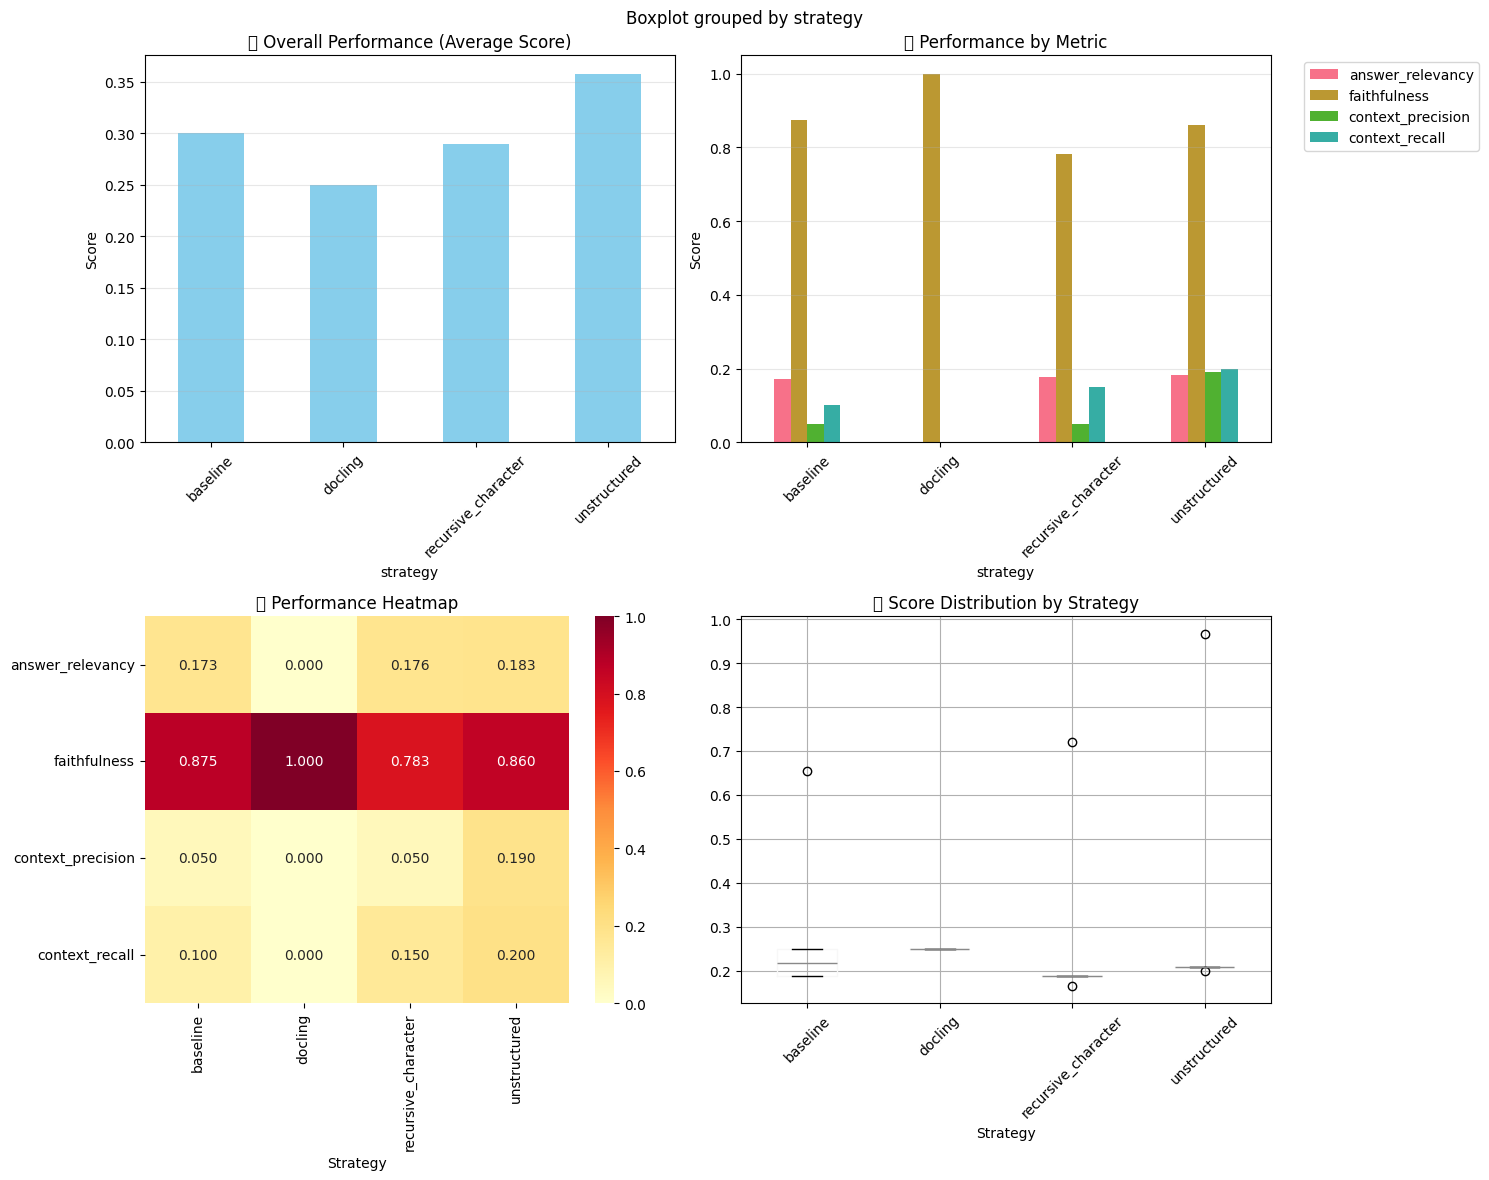

📊 Plots saved to: /Users/maharora/Documents/retrieval-playground/retrieval_playground/data/results/chunking_evaluation_plots.png


In [7]:
# Strategy comparison - average scores
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('📊 Chunking Strategy Performance Comparison', fontsize=16, fontweight='bold')

# Calculate average scores by strategy
strategy_avg = results_df.groupby('strategy').agg({
    'answer_relevancy': 'mean',
    'faithfulness': 'mean',
    'context_precision': 'mean',
    'context_recall': 'mean',
    'average_score': 'mean'
}).round(3)

# 1. Overall Performance
strategy_avg['average_score'].plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('🎯 Overall Performance (Average Score)')
axes[0,0].set_ylabel('Score')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(axis='y', alpha=0.3)

# 2. Metric breakdown
metrics_df = strategy_avg[['answer_relevancy', 'faithfulness', 'context_precision', 'context_recall']]
metrics_df.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('📈 Performance by Metric')
axes[0,1].set_ylabel('Score')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0,1].grid(axis='y', alpha=0.3)

# 3. Heatmap of all metrics
sns.heatmap(metrics_df.T, annot=True, cmap='YlOrRd', ax=axes[1,0], fmt='.3f')
axes[1,0].set_title('🔥 Performance Heatmap')
axes[1,0].set_xlabel('Strategy')

# 4. Box plot showing distribution
results_df.boxplot(column='average_score', by='strategy', ax=axes[1,1])
axes[1,1].set_title('📦 Score Distribution by Strategy')
axes[1,1].set_xlabel('Strategy')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Save the plot
plot_file = config.RESULTS_DIR / "chunking_evaluation_plots.png"
fig.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"📊 Plots saved to: {plot_file}")


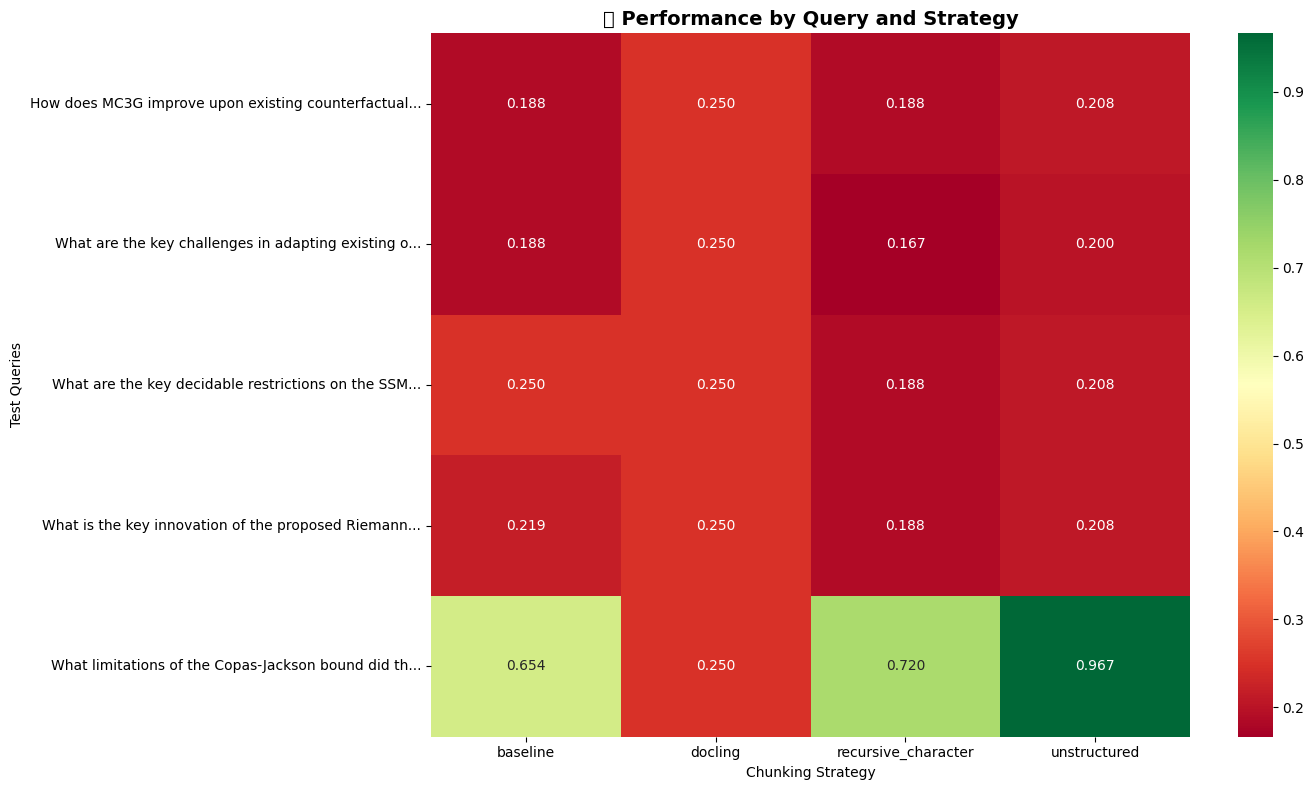


💡 Interpretation Guide:
🟢 Green: Better performance
🟡 Yellow: Average performance
🟠 Orange/Red: Lower performance


In [8]:
# Detailed per-query analysis
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Create a pivot table for better visualization
pivot_df = results_df.pivot_table(
    values='average_score', 
    index='queries', 
    columns='strategy', 
    aggfunc='mean'
)

# Plot heatmap
sns.heatmap(pivot_df, annot=True, cmap='RdYlGn', ax=ax, fmt='.3f')
ax.set_title('🎯 Performance by Query and Strategy', fontsize=14, fontweight='bold')
ax.set_xlabel('Chunking Strategy')
ax.set_ylabel('Test Queries')

# Truncate long query names for better display
query_labels = [q[:50] + '...' if len(q) > 50 else q for q in pivot_df.index]
ax.set_yticklabels(query_labels, rotation=0)

plt.tight_layout()
plt.show()

print("\n💡 Interpretation Guide:")
print("🟢 Green: Better performance")
print("🟡 Yellow: Average performance")
print("🟠 Orange/Red: Lower performance")


## 💡 Recommendations and Best Practices

Based on the evaluation results, let's provide some recommendations:


In [10]:
# Generate recommendations based on results
best_overall = strategy_avg['average_score'].idxmax()
best_relevancy = strategy_avg['answer_relevancy'].idxmax()
best_faithfulness = strategy_avg['faithfulness'].idxmax()
best_precision = strategy_avg['context_precision'].idxmax()
best_recall = strategy_avg['context_recall'].idxmax()

print("🎯 RECOMMENDATIONS BASED ON EVALUATION")
print("="*60)

print(f"\n🏆 BEST OVERALL STRATEGY: {best_overall.upper()}")
print(f"   Score: {strategy_avg.loc[best_overall, 'average_score']:.3f}")
print(f"   This strategy provides the best balanced performance across all metrics.")

print(f"\n🎯 SPECIALIZED RECOMMENDATIONS:")
print(f"   📝 Best for Answer Quality: {best_relevancy.upper()} ({strategy_avg.loc[best_relevancy, 'answer_relevancy']:.3f})")
print(f"   🔒 Most Faithful to Context: {best_faithfulness.upper()} ({strategy_avg.loc[best_faithfulness, 'faithfulness']:.3f})")
print(f"   🎯 Best Context Precision: {best_precision.upper()} ({strategy_avg.loc[best_precision, 'context_precision']:.3f})")
print(f"   📚 Best Context Recall: {best_recall.upper()} ({strategy_avg.loc[best_recall, 'context_recall']:.3f})")

print(f"\n💼 USE CASE RECOMMENDATIONS:")
print(f"   🚀 For Speed: baseline (fastest, simplest)")
print(f"   ⚖️ For Balance: recursive_character (good performance/complexity ratio)")
print(f"   📄 For Academic Papers: unstructured (structure-aware)")
print(f"   🎯 For Complex Documents: docling (best structure preservation)")

# Performance insights
performance_gap = strategy_avg['average_score'].max() - strategy_avg['average_score'].min()
print(f"\n📊 PERFORMANCE INSIGHTS:")
print(f"   📈 Performance Gap: {performance_gap:.3f} ({performance_gap/strategy_avg['average_score'].min()*100:.1f}% improvement)")
print(f"   🔄 Strategy Choice Impact: {'HIGH' if performance_gap > 0.1 else 'MODERATE' if performance_gap > 0.05 else 'LOW'}")

if performance_gap > 0.1:
    print(f"   ⚡ Recommendation: Strategy selection is CRITICAL for your use case")
elif performance_gap > 0.05:
    print(f"   ⚖️  Recommendation: Consider trade-offs between performance and complexity")
else:
    print(f"   ✅ Recommendation: Most strategies perform similarly, choose based on requirements")


🎯 RECOMMENDATIONS BASED ON EVALUATION

🏆 BEST OVERALL STRATEGY: UNSTRUCTURED
   Score: 0.358
   This strategy provides the best balanced performance across all metrics.

🎯 SPECIALIZED RECOMMENDATIONS:
   📝 Best for Answer Quality: UNSTRUCTURED (0.183)
   🔒 Most Faithful to Context: DOCLING (1.000)
   🎯 Best Context Precision: UNSTRUCTURED (0.190)
   📚 Best Context Recall: UNSTRUCTURED (0.200)

💼 USE CASE RECOMMENDATIONS:
   🚀 For Speed: baseline (fastest, simplest)
   ⚖️ For Balance: recursive_character (good performance/complexity ratio)
   📄 For Academic Papers: unstructured (structure-aware)
   🎯 For Complex Documents: docling (best structure preservation)

📊 PERFORMANCE INSIGHTS:
   📈 Performance Gap: 0.108 (43.2% improvement)
   🔄 Strategy Choice Impact: HIGH
   ⚡ Recommendation: Strategy selection is CRITICAL for your use case


## 🚀 NEXT STEPS FOR ADVANCED USAGE
---

### 1. 🔧 CUSTOMIZE CHUNKING PARAMETERS
- Adjust `chunk_size` and `chunk_overlap` in **chunking_strategies.py**  
- Experiment with different separators for **RecursiveCharacterTextSplitter**  
- Modify **Docling's HybridChunker** `max_tokens` parameter  

### 2. 📊 EXPAND EVALUATION
- Add more test queries in **test_queries.json**  
- Include domain-specific evaluation metrics  
- Test with different document types (not just research papers)  

### 3. 🎯 OPTIMIZE FOR YOUR USE CASE
- Create custom chunking strategies for your document types  
- Implement domain-specific preprocessing  
- Add metadata enrichment during chunking  

### 4. 🔍 ANALYZE CHUNK QUALITY
- Examine individual chunks for quality assessment  
- Analyze chunk size distribution  
- Check for information loss at chunk boundaries  

### 5. 📈 PRODUCTION CONSIDERATIONS
- Benchmark processing speed for each strategy  
- Monitor memory usage during chunk creation  
- Implement caching for frequently accessed documents  

---

💡 **TIP**: Run this evaluation regularly when:  
- Adding new document types to your corpus  
- Changing your RAG system architecture  
- Updating embedding models or LLMs  
- Optimizing for new performance requirements  


## 📝 Summary

This notebook demonstrated:

✅ **Chunking Strategy Overview**: Understanding different approaches to document chunking

✅ **Evaluation Framework**: Using RAGAS metrics to assess chunking performance

✅ **Comparative Analysis**: Visualizing and interpreting results across strategies

✅ **Practical Recommendations**: Guidelines for choosing the right strategy

### 🎯 Key Takeaways:
- **No one-size-fits-all**: Different strategies excel in different scenarios
- **Trade-offs matter**: Consider performance vs. complexity vs. speed
- **Context is king**: Document type and use case should guide strategy selection
- **Measure and iterate**: Regular evaluation helps optimize your RAG system

### 🔄 Remember:
The "best" chunking strategy depends on your specific use case, documents, and performance requirements. Use this evaluation framework to make data-driven decisions for your RAG system!

---
*Happy chunking! 🎉*
